# Board prediction example

Provided a chessboard screen capture (has to be perfectly square), the board will be splitted into 64 squares and the classifier will try to predict each square and then reassemble the entire board

In [125]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img # type: ignore
import matplotlib.pyplot as plt
import chess

In [126]:
# Load the trained model
model_name = "chess_classifier_10k"
model = tf.keras.models.load_model(f"models/{model_name}.keras")

In [127]:
# Define class labels as per the training data
class_labels = [
    "b_bishop",
    "b_king",
    "b_knight",
    "b_pawn",
    "b_queen",
    "b_rook",
    "empty",
    "w_bishop",
    "w_king",
    "w_knight",
    "w_pawn",
    "w_queen",
    "w_rook",
]

In [128]:
# Map class labels to FEN pieces
class_to_fen = {
    "b_bishop": "b",
    "b_king": "k",
    "b_knight": "n",
    "b_pawn": "p",
    "b_queen": "q",
    "b_rook": "r",
    "empty": "1",
    "w_bishop": "B",
    "w_king": "K",
    "w_knight": "N",
    "w_pawn": "P",
    "w_queen": "Q",
    "w_rook": "R",
}

In [129]:
# Function to preprocess and classify a single square
def classify_square(img):
    img = img.resize((224, 224))  # Resize to match model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale
    prediction = model.predict(img_array, verbose=False)
    class_index = np.argmax(prediction, axis=1)[0]
    return class_labels[class_index]


# Function to classify the entire chessboard
def classify_chessboard(chessboard_image_path):
    chessboard = load_img(chessboard_image_path)
    board_size = chessboard.size[0] // 8
    board_configuration = []

    for row in range(8):
        row_configuration = []
        for col in range(8):
            left = col * board_size
            upper = row * board_size
            right = left + board_size
            lower = upper + board_size
            square = chessboard.crop((left, upper, right, lower))
            classification = classify_square(square)
            row_configuration.append(classification)
        board_configuration.append(row_configuration)

    return board_configuration


# Visualize the board configuration
def visualize_board(board_configuration):
    fig, ax = plt.subplots()
    table = plt.table(cellText=board_configuration, cellLoc="center", loc="center")
    table.scale(1, 2)
    ax.axis("off")
    plt.show()


# Function to convert board configuration to FEN
def board_to_fen(board_configuration):
    fen_rows = []
    for row in board_configuration:
        fen_row = ""
        empty_count = 0
        for square in row:
            fen_piece = class_to_fen[square]
            if fen_piece == "1":
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += fen_piece
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    fen = "/".join(fen_rows)
    return fen

In [130]:
chessboard_image_path = "test/test2.png"
board_configuration = classify_chessboard(chessboard_image_path)

for row in board_configuration:
    print(row)

['b_rook', 'empty', 'b_bishop', 'b_queen', 'b_king', 'b_bishop', 'b_knight', 'b_rook']
['b_pawn', 'b_pawn', 'empty', 'b_knight', 'empty', 'b_pawn', 'b_pawn', 'b_pawn']
['empty', 'empty', 'b_pawn', 'empty', 'empty', 'empty', 'empty', 'empty']
['empty', 'empty', 'empty', 'b_pawn', 'b_pawn', 'empty', 'empty', 'empty']
['empty', 'w_pawn', 'empty', 'w_pawn', 'w_pawn', 'empty', 'empty', 'empty']
['empty', 'empty', 'w_knight', 'empty', 'empty', 'empty', 'empty', 'empty']
['w_pawn', 'empty', 'w_pawn', 'empty', 'w_knight', 'w_pawn', 'w_pawn', 'w_pawn']
['w_rook', 'empty', 'w_bishop', 'w_queen', 'w_king', 'w_bishop', 'empty', 'w_rook']


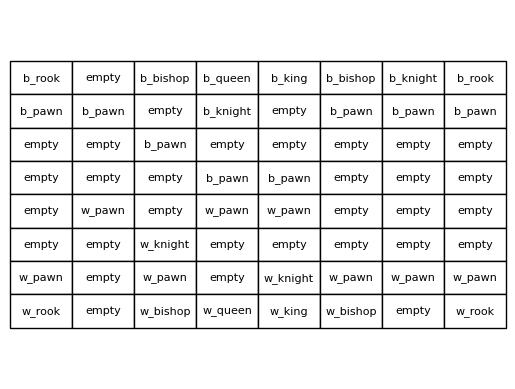

In [131]:
visualize_board(board_configuration)

In [132]:
fen = board_to_fen(board_configuration)
fen

'r1bqkbnr/pp1n1ppp/2p5/3pp3/1P1PP3/2N5/P1P1NPPP/R1BQKB1R'

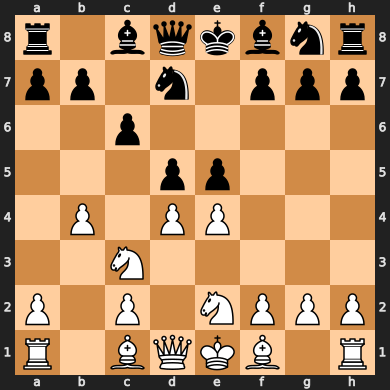

In [133]:
chess.Board(fen=fen)